# Implémentez un modèle de scoring…


Etude data - Projet 7 - Nicolas Pasero (Mars 2021)

Traitement des données sur Jupyter Notebook (Distribution Anaconda)

Etude réalisée en langage Python

*Data source* : [Jeu de données d’articles](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip)

___Inspiré par le Kernel :___

https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

https://www.kaggle.com/danilz/merge-all-data-base-glm-vs-xgb-explained-0-763

---

Société financière qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.


L’entreprise souhaite **développer un modèle de scoring de la probabilité de défaut de paiement du client** pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de **transparence** vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Elle décide donc de développer un **dashboard interactif** pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

### Mission

1. Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
2. Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle et d’améliorer la connaissance client des chargés de relation client.

Michaël, manager, incite à sélectionner un kernel Kaggle pour faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring. L'idée est d'analyser ce kernel pour l'adapter aux besoins de la mission.

### Spécifications du dashboard
Michaël fourni un cahier des charges pour le dashboard interactif. Celui-ci devra a minima contenir les fonctionnalités suivantes :

- Permettre de visualiser le score et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
- Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).
- Permettre de comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.

---

In [1]:
#Essential data science libraries
import pandas as pd
import seaborn as sns
import glob
import pickle
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [3]:
#Graphing…
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':25,
     'ytick.labelsize':25,
     'axes.labelsize': 25,
     'legend.fontsize': 25,
     'axes.titlesize':45,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

## Chargement des données et Analyse exploratoire

### Data description from [Kaggle](https://www.kaggle.com/c/home-credit-default-risk/data) : 


#### application_{train|test}.csv
This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

#### bureau.csv
All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

#### bureau_balance.csv
Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

#### POS_CASH_balance.csv
Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

#### credit_card_balance.csv
Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

#### previous_application.csv
All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

#### installments_payments.csv
Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

#### HomeCredit_columns_description.csv
This file contains descriptions for the columns in the various data files.

In [4]:
print("CHECKLIST DATA EXPLORER :")
display(os.listdir('./data/'))

CHECKLIST DATA EXPLORER :


['application_test.csv',
 '.DS_Store',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 'previous_application.csv',
 'bureau_balance.csv',
 'sample_submission.csv']

In [5]:
%%time 
application_train = pd.read_csv('data/application_train.csv')
application_test = pd.read_csv('data/application_test.csv')
bureau = pd.read_csv('data/bureau.csv')
bureau_balance = pd.read_csv('data/bureau_balance.csv')
credit_card_balance = pd.read_csv('data/credit_card_balance.csv')
installments_payments = pd.read_csv('data/installments_payments.csv')
POS_CASH_balance = pd.read_csv('data/POS_CASH_balance.csv')
previous_application = pd.read_csv('data/previous_application.csv')

CPU times: user 33.8 s, sys: 5.61 s, total: 39.4 s
Wall time: 39.8 s


In [7]:
print("DOCUMENTATION :")
pd.set_option("max_colwidth", 400)
description = pd.read_csv('data/HomeCredit_columns_description.csv',  encoding="ISO-8859-1")
description

DOCUMENTATION :


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


In [14]:
def data_describe(folder):
    '''Check the number of rows, columns, missing values and duplicates.
       Count type of columns.
       Memory indication'''

    data_dict = {}
    for file in folder:
        data = pd.read_csv(file)
        data_dict[file] = [data.shape[0], 
                           data.shape[1],
                            round(data.isna().sum().sum()/data.size*100, 2),
                            round(data.duplicated().sum().sum()/data.size*100, 2),
                            data.select_dtypes(include=['object']).shape[1],
                            data.select_dtypes(include=['float']).shape[1],
                            data.select_dtypes(include=['int']).shape[1],
                            data.select_dtypes(include=['bool']).shape[1],
                            round(data.memory_usage().sum()/1024**2, 3)]

        comparative_table = pd.DataFrame.from_dict(data = data_dict, 
                                                   columns = ['Rows', 'Columns', '%NaN', '%Duplicate', 
                                                              'object_dtype','float_dtype', 'int_dtype', 
                                                              'bool_dtype', 'MB_Memory'], 
                                                   orient='index')
    print("SUMMARY FILES…")
    return(comparative_table)

In [15]:
#Data description
data_describe(folder = glob.glob('./data/*.csv'))

SUMMARY FILES…


,Rows,Columns,%NaN,%Duplicate,object_dtype,float_dtype,int_dtype,bool_dtype,MB_Memory
./data/application_test.csv,48744,121,23.81,0.0,16,65,40,0,44.998
./data/POS_CASH_balance.csv,10001358,8,0.07,0.0,1,2,5,0,610.435
./data/credit_card_balance.csv,3840312,23,6.65,0.0,1,15,7,0,673.883
./data/installments_payments.csv,13605401,8,0.01,0.0,0,5,3,0,830.408
./data/application_train.csv,307511,122,24.40,0.0,16,65,41,0,286.227
./data/bureau.csv,1716428,17,13.50,0.0,3,8,6,0,222.620
./data/previous_application.csv,1670214,37,17.98,0.0,16,15,6,0,471.481
./data/bureau_balance.csv,27299925,3,0.00,0.0,1,0,2,0,624.846
./data/sample_submission.csv,48744,2,0.00,0.0,0,1,1,0,0.744


In [16]:
def features(folder):
    '''Comparative data with missing values, 
       and many descriptive statistics.'''
    
    data_object = {}
    data_numeric = {}
    
    for file in folder:
        data = pd.read_csv(file)
        
        data_object[file] = [(x, data[x].dtype, 
                              data[x].isna().sum().sum(),
                              int(data[x].count())) for x in data.select_dtypes(exclude=['int', 'float'])]
        
        data_numeric[file] = [(x, data[x].dtype, 
                               int(data[x].isna().sum().sum()), 
                               int(data[x].count()), 
                               int(data[x].mean()), 
                               round(data[x].std(),1),
                               round(data[x].min(),1), 
                               round(data[x].max(),1)) for x in data.select_dtypes(exclude='object')]
        

    comparative_object = pd.DataFrame.from_dict(data = data_object, orient='index')
    dict_of_object = {name: pd.DataFrame(file) for name,file in data_object.items()}
    df1 = pd.concat(dict_of_object, axis=0)
    df1.columns=['features','dtype','nan','count']
    
    comparative_numeric = pd.DataFrame.from_dict(data = data_numeric, orient='index')
    dict_of_numeric = {name: pd.DataFrame(file) for name,file in data_numeric.items()}
    df2 = pd.concat(dict_of_numeric, axis=0)
    df2.columns=['features','dtype','nan','count', 'mean', 'std', 'min','max']
        
    return df1, df2

In [17]:
#Data description
features(folder=glob.glob('./data/*.csv'))[0]

features   dtype  \
./data/application_test.csv     0            NAME_CONTRACT_TYPE  object   
                                1                   CODE_GENDER  object   
                                2                  FLAG_OWN_CAR  object   
                                3               FLAG_OWN_REALTY  object   
                                4               NAME_TYPE_SUITE  object   
                                5              NAME_INCOME_TYPE  object   
                                6           NAME_EDUCATION_TYPE  object   
                                7            NAME_FAMILY_STATUS  object   
                                8             NAME_HOUSING_TYPE  object   
                                9               OCCUPATION_TYPE  object   
                                10   WEEKDAY_APPR_PROCESS_START  object   
                                11            ORGANIZATION_TYPE  object   
                                12           FONDKAPREMONT_MODE  object   
                                13               HOUSETYPE_MODE  object   
                                14           WALLSMATERIAL_MODE  object   
                                15          EMERGENCYSTATE_MODE  object   
./data/POS_CASH_balance.csv     0          NAME_CONTRACT_STATUS  object   
./data/credit_card_balance.csv  0          NAME_CONTRACT_STATUS  object   
./data/application_train.csv    0            NAME_CONTRACT_TYPE  object   
                                1                   CODE_GENDER  object   
                                2                  FLAG_OWN_CAR  object   
                                3               FLAG_OWN_REALTY  object   
                                4               NAME_TYPE_SUITE  object   
                                5              NAME_INCOME_TYPE  object   
                                6           NAME_EDUCATION_TYPE  object   
                                7            NAME_FAMILY_STATUS  object   
                                8             NAME_HOUSING_TYPE  object   
                                9               OCCUPATION_TYPE  object   
                                10   WEEKDAY_APPR_PROCESS_START  object   
                                11            ORGANIZATION_TYPE  object   
                                12           FONDKAPREMONT_MODE  object   
                                13               HOUSETYPE_MODE  object   
                                14           WALLSMATERIAL_MODE  object   
                                15          EMERGENCYSTATE_MODE  object   
./data/bureau.csv               0                 CREDIT_ACTIVE  object   
                                1               CREDIT_CURRENCY  object   
                                2                   CREDIT_TYPE  object   
./data/previous_application.csv 0            NAME_CONTRACT_TYPE  object   
                                1    WEEKDAY_APPR_PROCESS_START  object   
                                2   FLAG_LAST_APPL_PER_CONTRACT  object   
                                3        NAME_CASH_LOAN_PURPOSE  object   
                                4          NAME_CONTRACT_STATUS  object   
                                5             NAME_PAYMENT_TYPE  object   
                                6            CODE_REJECT_REASON  object   
                                7               NAME_TYPE_SUITE  object   
                                8              NAME_CLIENT_TYPE  object   
                                9           NAME_GOODS_CATEGORY  object   
                                10               NAME_PORTFOLIO  object   
                                11            NAME_PRODUCT_TYPE  object   
                                12                 CHANNEL_TYPE  object   
                                13         NAME_SELLER_INDUSTRY  object   
                                14             NAME_YIELD_GROUP  object   
                                15          PRODUCT_COMBINATION  object   
./dat

In [18]:
#Data description
features(folder=glob.glob('./data/*.csv'))[1]

features    dtype  \
./data/application_test.csv      0                      SK_ID_CURR    int64   
                                 1                    CNT_CHILDREN    int64   
                                 2                AMT_INCOME_TOTAL  float64   
                                 3                      AMT_CREDIT  float64   
                                 4                     AMT_ANNUITY  float64   
                                 5                 AMT_GOODS_PRICE  float64   
                                 6      REGION_POPULATION_RELATIVE  float64   
                                 7                      DAYS_BIRTH    int64   
                                 8                   DAYS_EMPLOYED    int64   
                                 9               DAYS_REGISTRATION  float64   
                                 10                DAYS_ID_PUBLISH    int64   
                                 11                    OWN_CAR_AGE  float64   
                                 12                     FLAG_MOBIL    int64   
                                 13                 FLAG_EMP_PHONE    int64   
                                 14                FLAG_WORK_PHONE    int64   
                                 15               FLAG_CONT_MOBILE    int64   
                                 16                     FLAG_PHONE    int64   
                                 17                     FLAG_EMAIL    int64   
                                 18                CNT_FAM_MEMBERS  float64   
                                 19           REGION_RATING_CLIENT    int64   
                                 20    REGION_RATING_CLIENT_W_CITY    int64   
                                 21        HOUR_APPR_PROCESS_START    int64   
                                 22     REG_REGION_NOT_LIVE_REGION    int64   
                                 23     REG_REGION_NOT_WORK_REGION    int64   
                                 24    LIVE_REGION_NOT_WORK_REGION    int64   
                                 25         REG_CITY_NOT_LIVE_CITY    int64   
                                 26         REG_CITY_NOT_WORK_CITY    int64   
                                 27        LIVE_CITY_NOT_WORK_CITY    int64   
                                 28                   EXT_SOURCE_1  float64   
                                 29                   EXT_SOURCE_2  float64   
                                 30                   EXT_SOURCE_3  float64   
                                 31                 APARTMENTS_AVG  float64   
                                 32               BASEMENTAREA_AVG  float64   
                                 33    YEARS_BEGINEXPLUATATION_AVG  float64   
                                 34                YEARS_BUILD_AVG  float64   
                                 35                 COMMONAREA_AVG  float64   
                                 36                  ELEVATORS_AVG  float64   
                                 37                  ENTRANCES_AVG  float64   
                                 38                  FLOORSMAX_AVG  float64   
                                 39                  FLOORSMIN_AVG  float64   
                                 40                   LANDAREA_AVG  float64   
                                 41           LIVINGAPARTMENTS_AVG  float64   
                                 42                 LIVINGAREA_AVG  float64   
                                 43        NONLIVINGAPARTMENTS_AVG  float64   
                                 44              NONLIVINGAREA_AVG  float64   
                                 45                APARTMENTS_MODE  float64   
                                 46              BASEMENTAREA_MODE  float64   
                                 47   YEARS_BEGINEXPLUATATION_MODE  float64   
                                 48               YEARS_BUILD_MODE  float64   
                                 49                COMMONAREA_MODE  float64   
                             

### EDA application_train.csv | test.csv
La première partie permet d'illustrer globalement les données disponibles. Il est nécessaire d'approfondir l'analyse des features du ou des principaux fichiers.

In [19]:
print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)

Training Features shape:  (307511, 122)
Testing Features shape:  (48744, 121)


In [20]:
#Check if 'TARGET' is the only difference ;-)
display(application_train.columns.difference(application_test.columns))
print("Check theses two files for Train (with TARGET) and Test (without TARGET).")

Index(['TARGET'], dtype='object')

Check theses two files for Train (with TARGET) and Test (without TARGET).


In [21]:
#Distribution of the Target Column
application_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

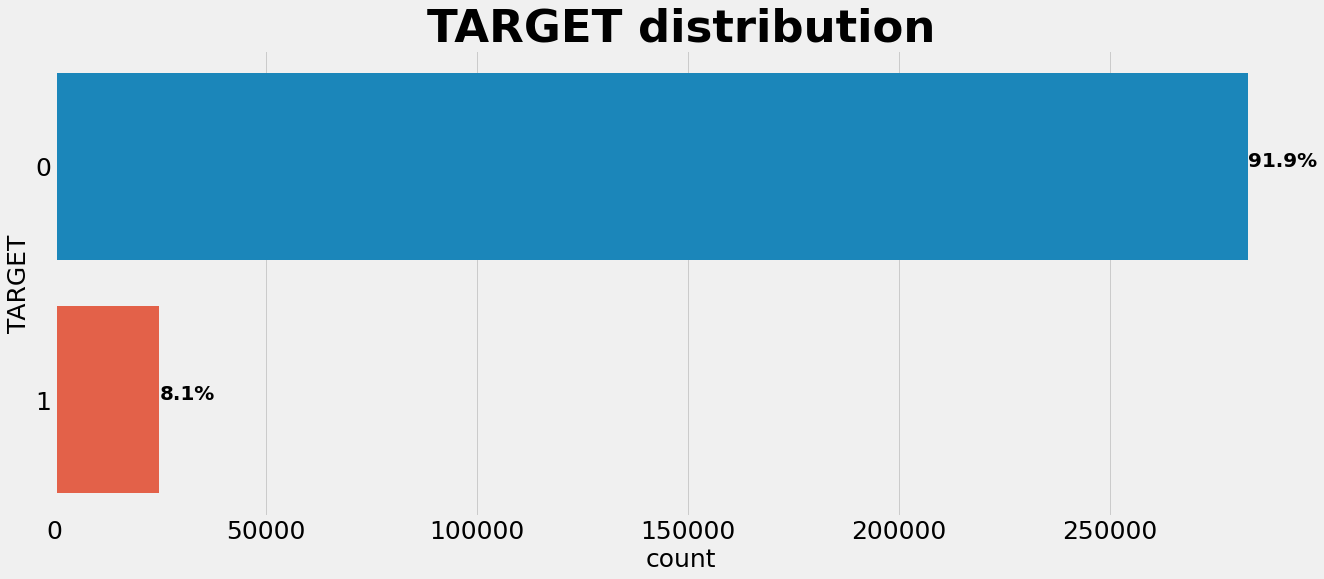

In [22]:
ax, fig = plt.subplots(figsize=(20,8)) 
ax = sns.countplot(y='TARGET', data=application_train)
ax.set_title("TARGET distribution")

for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/len(application_train.TARGET))
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')
        
show()

Notons des classes déséquilibrées. Il y a beaucoup plus de prêts remboursés à temps que de prêts non remboursés. Une fois que nous entrons dans des modèles d'apprentissage automatique plus sophistiqués, nous pouvons pondérer les classes par leur représentation dans les données pour refléter ce déséquilibre.

### Types de colonnes
Analyse rapide du type de features, mais surtout établir un aperçu afin de pouvoir poser une réflexion sur l'encodage des données catégorielles.

In [23]:
#Number of each type of column
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [24]:
#Number of unique classes in each object column
application_train.select_dtypes('object').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

La plupart des variables catégorielles ont un nombre relativement petit d'entrées uniques. Nous devrons trouver un moyen de traiter ces variables catégorielles…